# Imported Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from itertools import combinations

from tqdm import tqdm

sns.set_theme(context='notebook', style="whitegrid")

# Data Ingestion

In [ ]:
# Loading the listings data for both cities since that is what we are looking at
boston_listings = pd.read_csv('../project1_supplemental_files/airbnb_data/boston_listings.csv')
seattle_listings = pd.read_csv('../project1_supplemental_files/airbnb_data/seattle_listings.csv')

## Data Prep

In [ ]:
# Cleaning these column values to make it easier to use them later
seattle_listings['state'] = 'WA'
seattle_listings['city'] = 'Seattle'
boston_listings['state'] = 'MA'
boston_listings['city'] = 'Boston'

# Merging the two datasets together to be able to run the operations on them
combined_listings = pd.concat( [boston_listings, seattle_listings], ignore_index=True )

In [ ]:
# A list of columns that are not useful for analyzing at this stage due to complexity or amount of null values
cols_to_ignore = [
    'listing_url', 'scrape_id', 'last_scraped',
    'name', 'summary', 'space', 'description', 
    'experiences_offered', 'neighborhood_overview',
    'notes', 'transit', 'access', 'interaction',
    'house_rules', 'thumbnail_url', 'medium_url',
    'picture_url', 'xl_picture_url', 
    'host_id', 'host_url', 'host_name', 'host_since', 
    'host_location', 'host_about', 'host_thumbnail_url', 'host_has_profile_pic',
    'host_picture_url', 'street', 'neighbourhood',
    'neighbourhood_group_cleansed', 'zipcode', 'market', 'smart_location',
    'country_code', 'country', 'latitude', 'longitude', 
    'amenities', 'calendar_updated', 'has_availability', 'calendar_last_scraped',
    'license', 'jurisdiction_names', 'square_feet'
]
# Dropping the columns that are not useful for current analysis
combined_listings.drop(columns=cols_to_ignore, inplace=True)

# Mapping values of columns that are either 't' or 'f' to better values for graphing purposes
column_val_remapping = {
    'host_is_superhost': {'t': 'Superhost', 'f': 'Regular Host'},
    'requires_license': {'t': 'Yes', 'f': 'No'},
    'instant_bookable': {'t': 'Yes', 'f': 'No'},
    'require_guest_profile_picture': {'t': 'Yes', 'f': 'No'},
    'require_guest_phone_verification': {'t': 'Yes', 'f': 'No'},
    'host_identity_verified': {'t': 'Yes', 'f': 'No'},
}

def clean_up_cols(col):
    """
    Cleans up the columns of the dataset. Replaces dollar and percentage columns with float values for easier analysis. 
    Remaps the values in the columns in the above column_val_remapping dictionary. Lastly, fills in the host_verifications
    column with the number of verifications the host uses.

    Parameters:
    col (Series): The column to be evaluated for cleaning.

    Returns:
    Series: The same column with the values cleaned up.
    """
    if col.dtype == 'object':
        # If the column contains dollar or percentage values, replace the dollar/percentage sign and commas and convert to float
        if col.str.contains(r'[\$\%]').any():
            col = col.str.replace(r'[\%\$,]', '', regex=True).astype(float)

    # Remapping the values in the columns if the current column should be remapped
    if col.name in column_val_remapping:
        col = col.map( column_val_remapping[col.name] )

    # If the column is host_verifications, fill the count of the number of verification methods the host uses
    if col.name == 'host_verifications':
        col = col.fillna('')
        col = col.apply( lambda x: len( x.replace( r'[\[\]\'\"]', '' ).split(',') ) if ',' in x else 0 )

    return col

# Iterates throught the listings columns and cleans them up
for column in combined_listings.columns:
    combined_listings[column] = clean_up_cols( combined_listings[column] )

# Calculating Average Prices

## Helper methods used for bucketing review ratings and host response rates

In [7]:
def rate_to_points(rating):
    """
    Categorizes review rating or host response rate from listings into a 4 point grading system for easier display in graphs.

    Parameters:
    rating (float): The review rating or host response rate to be categorized.

    Returns:
    str: The letter grade corresponding to the rating.
    """
    # If the rating is missing, return 'N/A'
    if pd.isnull(rating):
        return 0
    # Otherwise, return the corresponding letter grade
    elif rating >= 90:
        return 4
    elif rating >= 80:
        return 3
    elif rating >= 70:
        return 2
    # If the rating is below 70, return 1
    return 1

def rate_to_grade(rating):
    """
    Categorizes review rating or host response rate from listings into a letter grade for easier display in graphs.

    Parameters:
    rating (float): The review rating or host response rate to be categorized.

    Returns:
    str: The letter grade corresponding to the rating.
    """
    # If the rating is missing, return 'N/A'
    if pd.isnull(rating):
        return 'N/A'
    # Otherwise, return the corresponding letter grade
    elif rating >= 90:
        return 'A'
    elif rating >= 80:
        return 'B'
    elif rating >= 70:
        return 'C'
    # If the rating is below 70, return 'F'
    return 'F'

## Average Prices by Superhost Status

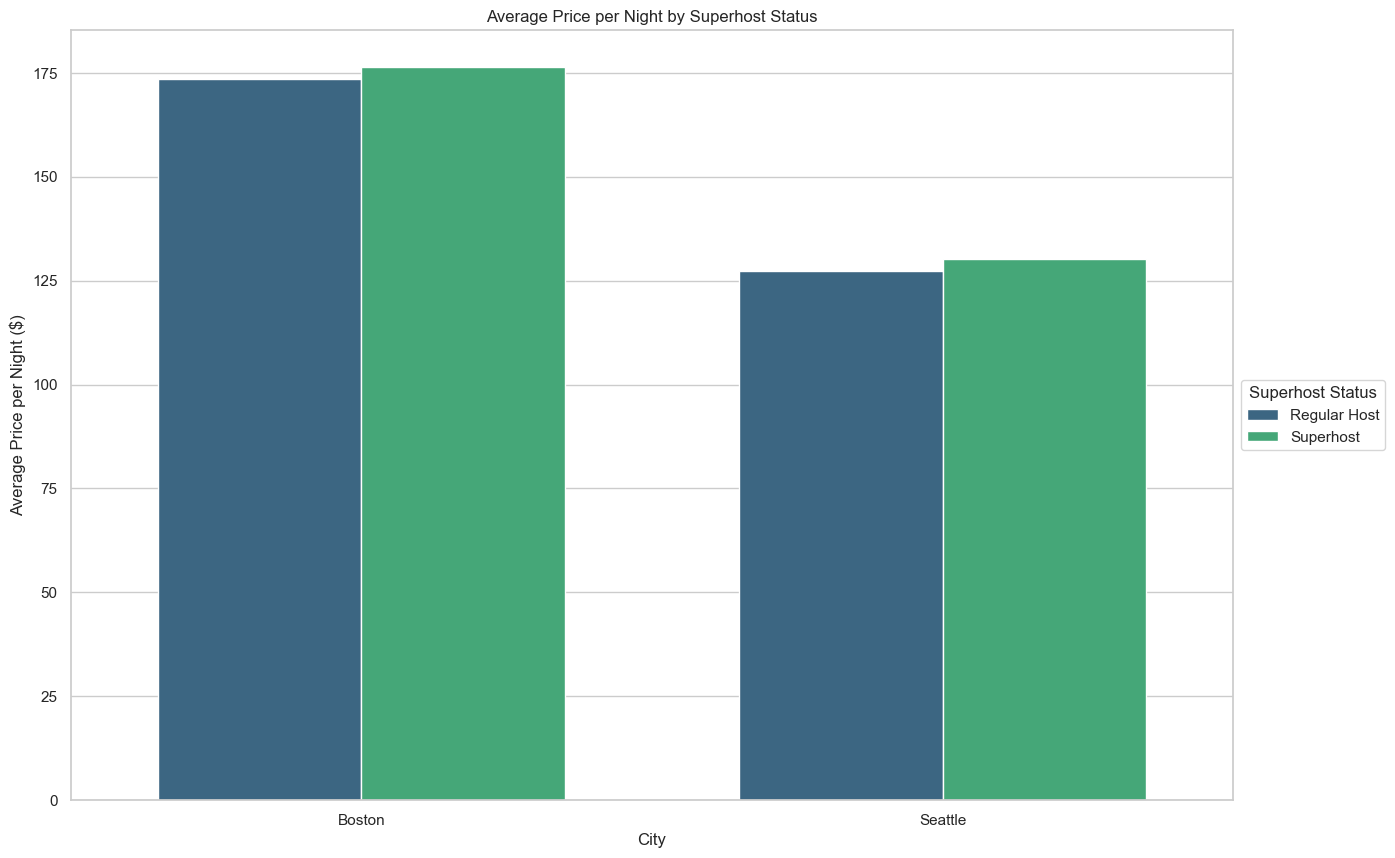

In [ ]:
# Get the average price per city and superhost status
average_price_per_superhost = combined_listings.groupby(['city', 'host_is_superhost'])['price'].mean().reset_index()
# Rounding the average price to 2 decimal places to cleaner display
average_price_per_superhost['price'] = average_price_per_superhost['price'].round(2)

# Plotting the average price per night by city and superhost status as a bar chart
plt.figure(figsize=(15, 10))
average_price_per_superhost_graph = sns.barplot( 
    data=average_price_per_superhost, x='city', y='price', hue='host_is_superhost', 
    palette='viridis', width=0.7
)
average_price_per_superhost_graph.set_title('Average Price per Night by Superhost Status')
average_price_per_superhost_graph.set_xlabel('City')
average_price_per_superhost_graph.set_ylabel('Average Price per Night ($)')
sns.move_legend( average_price_per_superhost_graph, loc='center left', bbox_to_anchor=(1, 0.5), title='Superhost Status' )

## Price per Review Bucket and Superhost Status

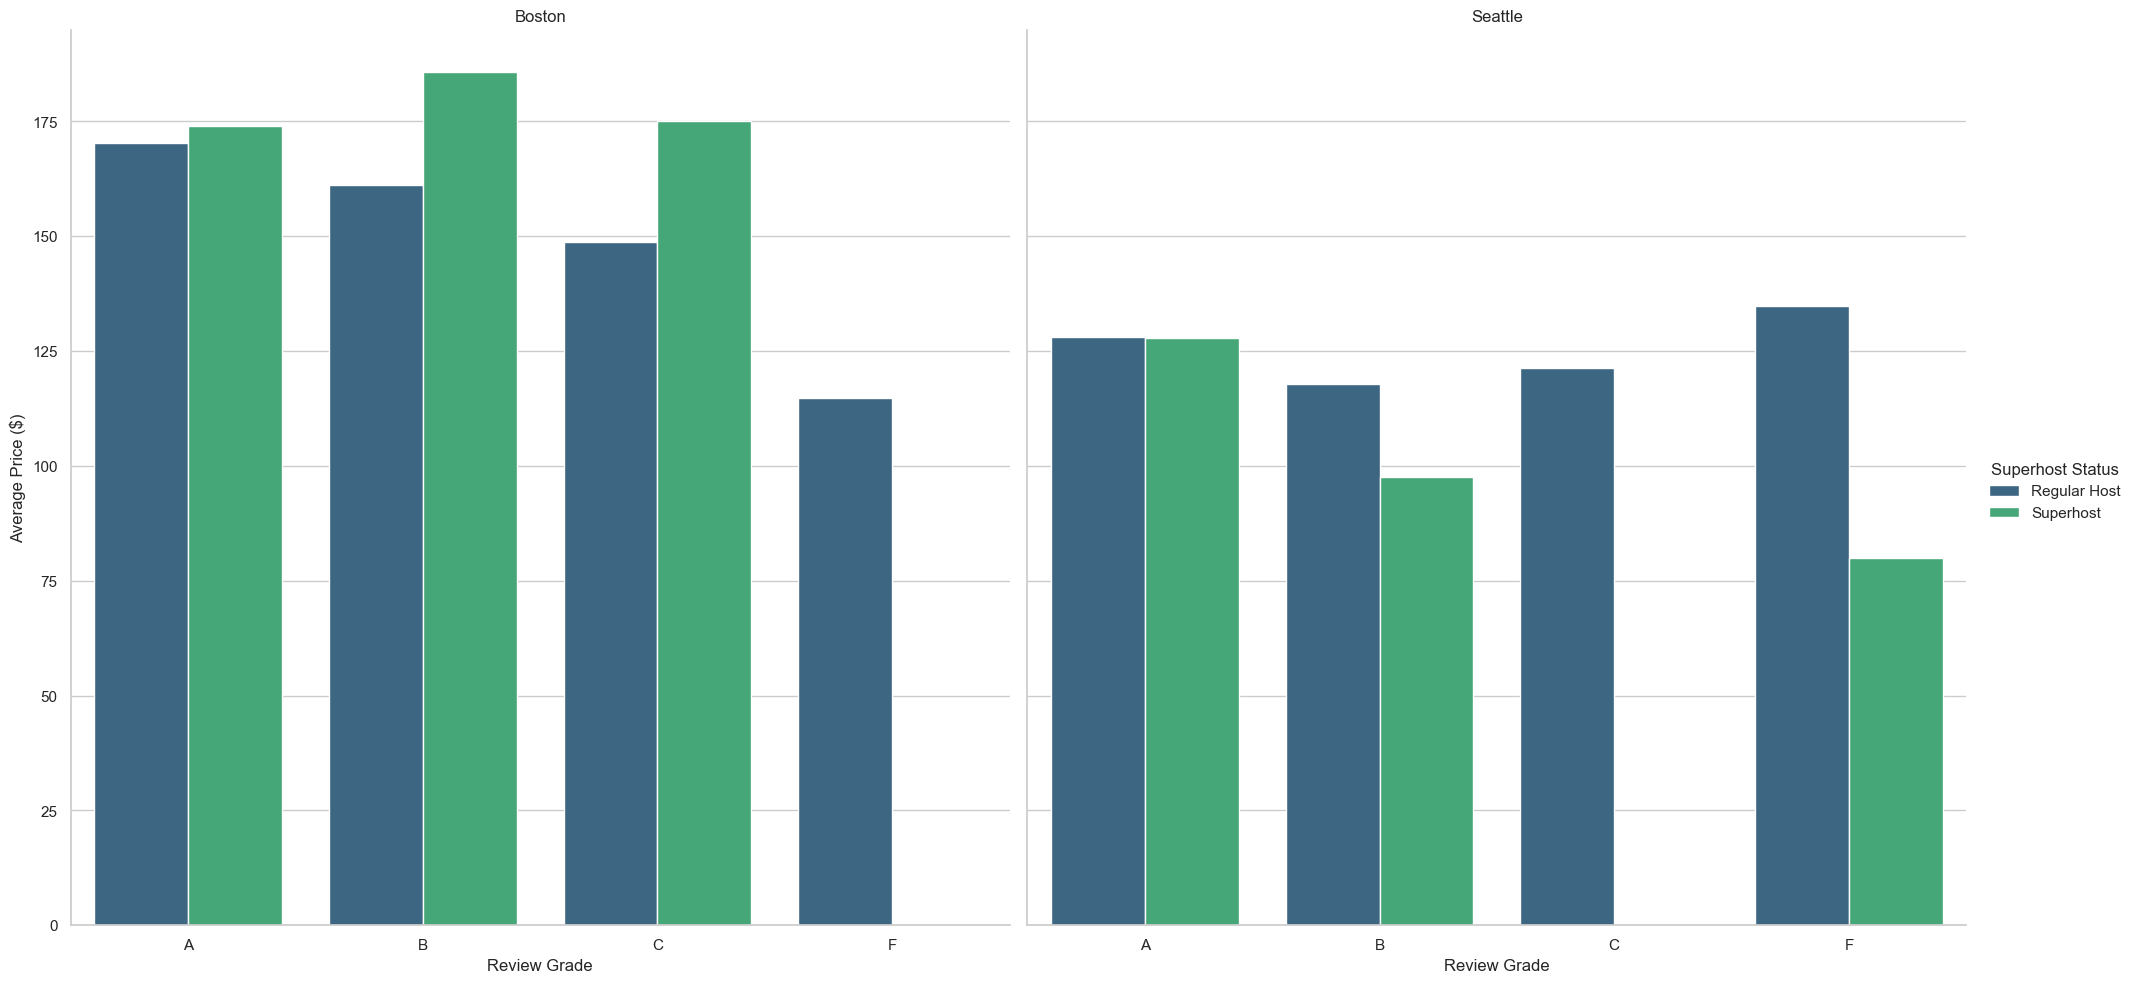

In [41]:
# Creating a copy of the combined listings dataframe and only keeping the columns that are needed for the analysis
prices_per_rating = combined_listings[ ['id', 'city', 'review_scores_rating', 'host_is_superhost', 'price'] ].copy()
# Renaming 'host_is_superhost' to 'Superhost Status' for better display in graph
prices_per_rating.rename(columns={'host_is_superhost': 'Superhost Status'}, inplace=True)
# Assigns a letter grade to the review rating
prices_per_rating['review_grade'] = prices_per_rating['review_scores_rating'].apply(rate_to_grade)

# Grouping the listings by city, review grade, and superhost status to get the average price
prices_per_rating = prices_per_rating \
                        .groupby( ['city', 'review_grade', 'Superhost Status'] ) \
                        .agg( average_price=('price', 'mean') ) \
                        .reset_index() \
                        .sort_values( by=['city', 'review_grade', 'Superhost Status'] )

# Rounding the average price to 2 decimal places to cleaner display
prices_per_rating['average_price'] = prices_per_rating['average_price'].round(2)

# Excluding the listings with no review rating
prices_per_rating = prices_per_rating[ prices_per_rating['review_grade'] != 'N/A' ]

# Plotting the average price per night by review grade, city, and superhost status as a bar chart
price_per_rating_graph = sns.catplot(
                            data=prices_per_rating, kind='bar',
                            x='review_grade', y='average_price', 
                            col='city', hue='Superhost Status', 
                            height=10, palette='viridis'
                        )
price_per_rating_graph.set_axis_labels('Review Grade', 'Average Price ($)')
price_per_rating_graph.set_titles('{col_name}')
plt.show()

# Host Response Rate and Review Grades by Superhost Status

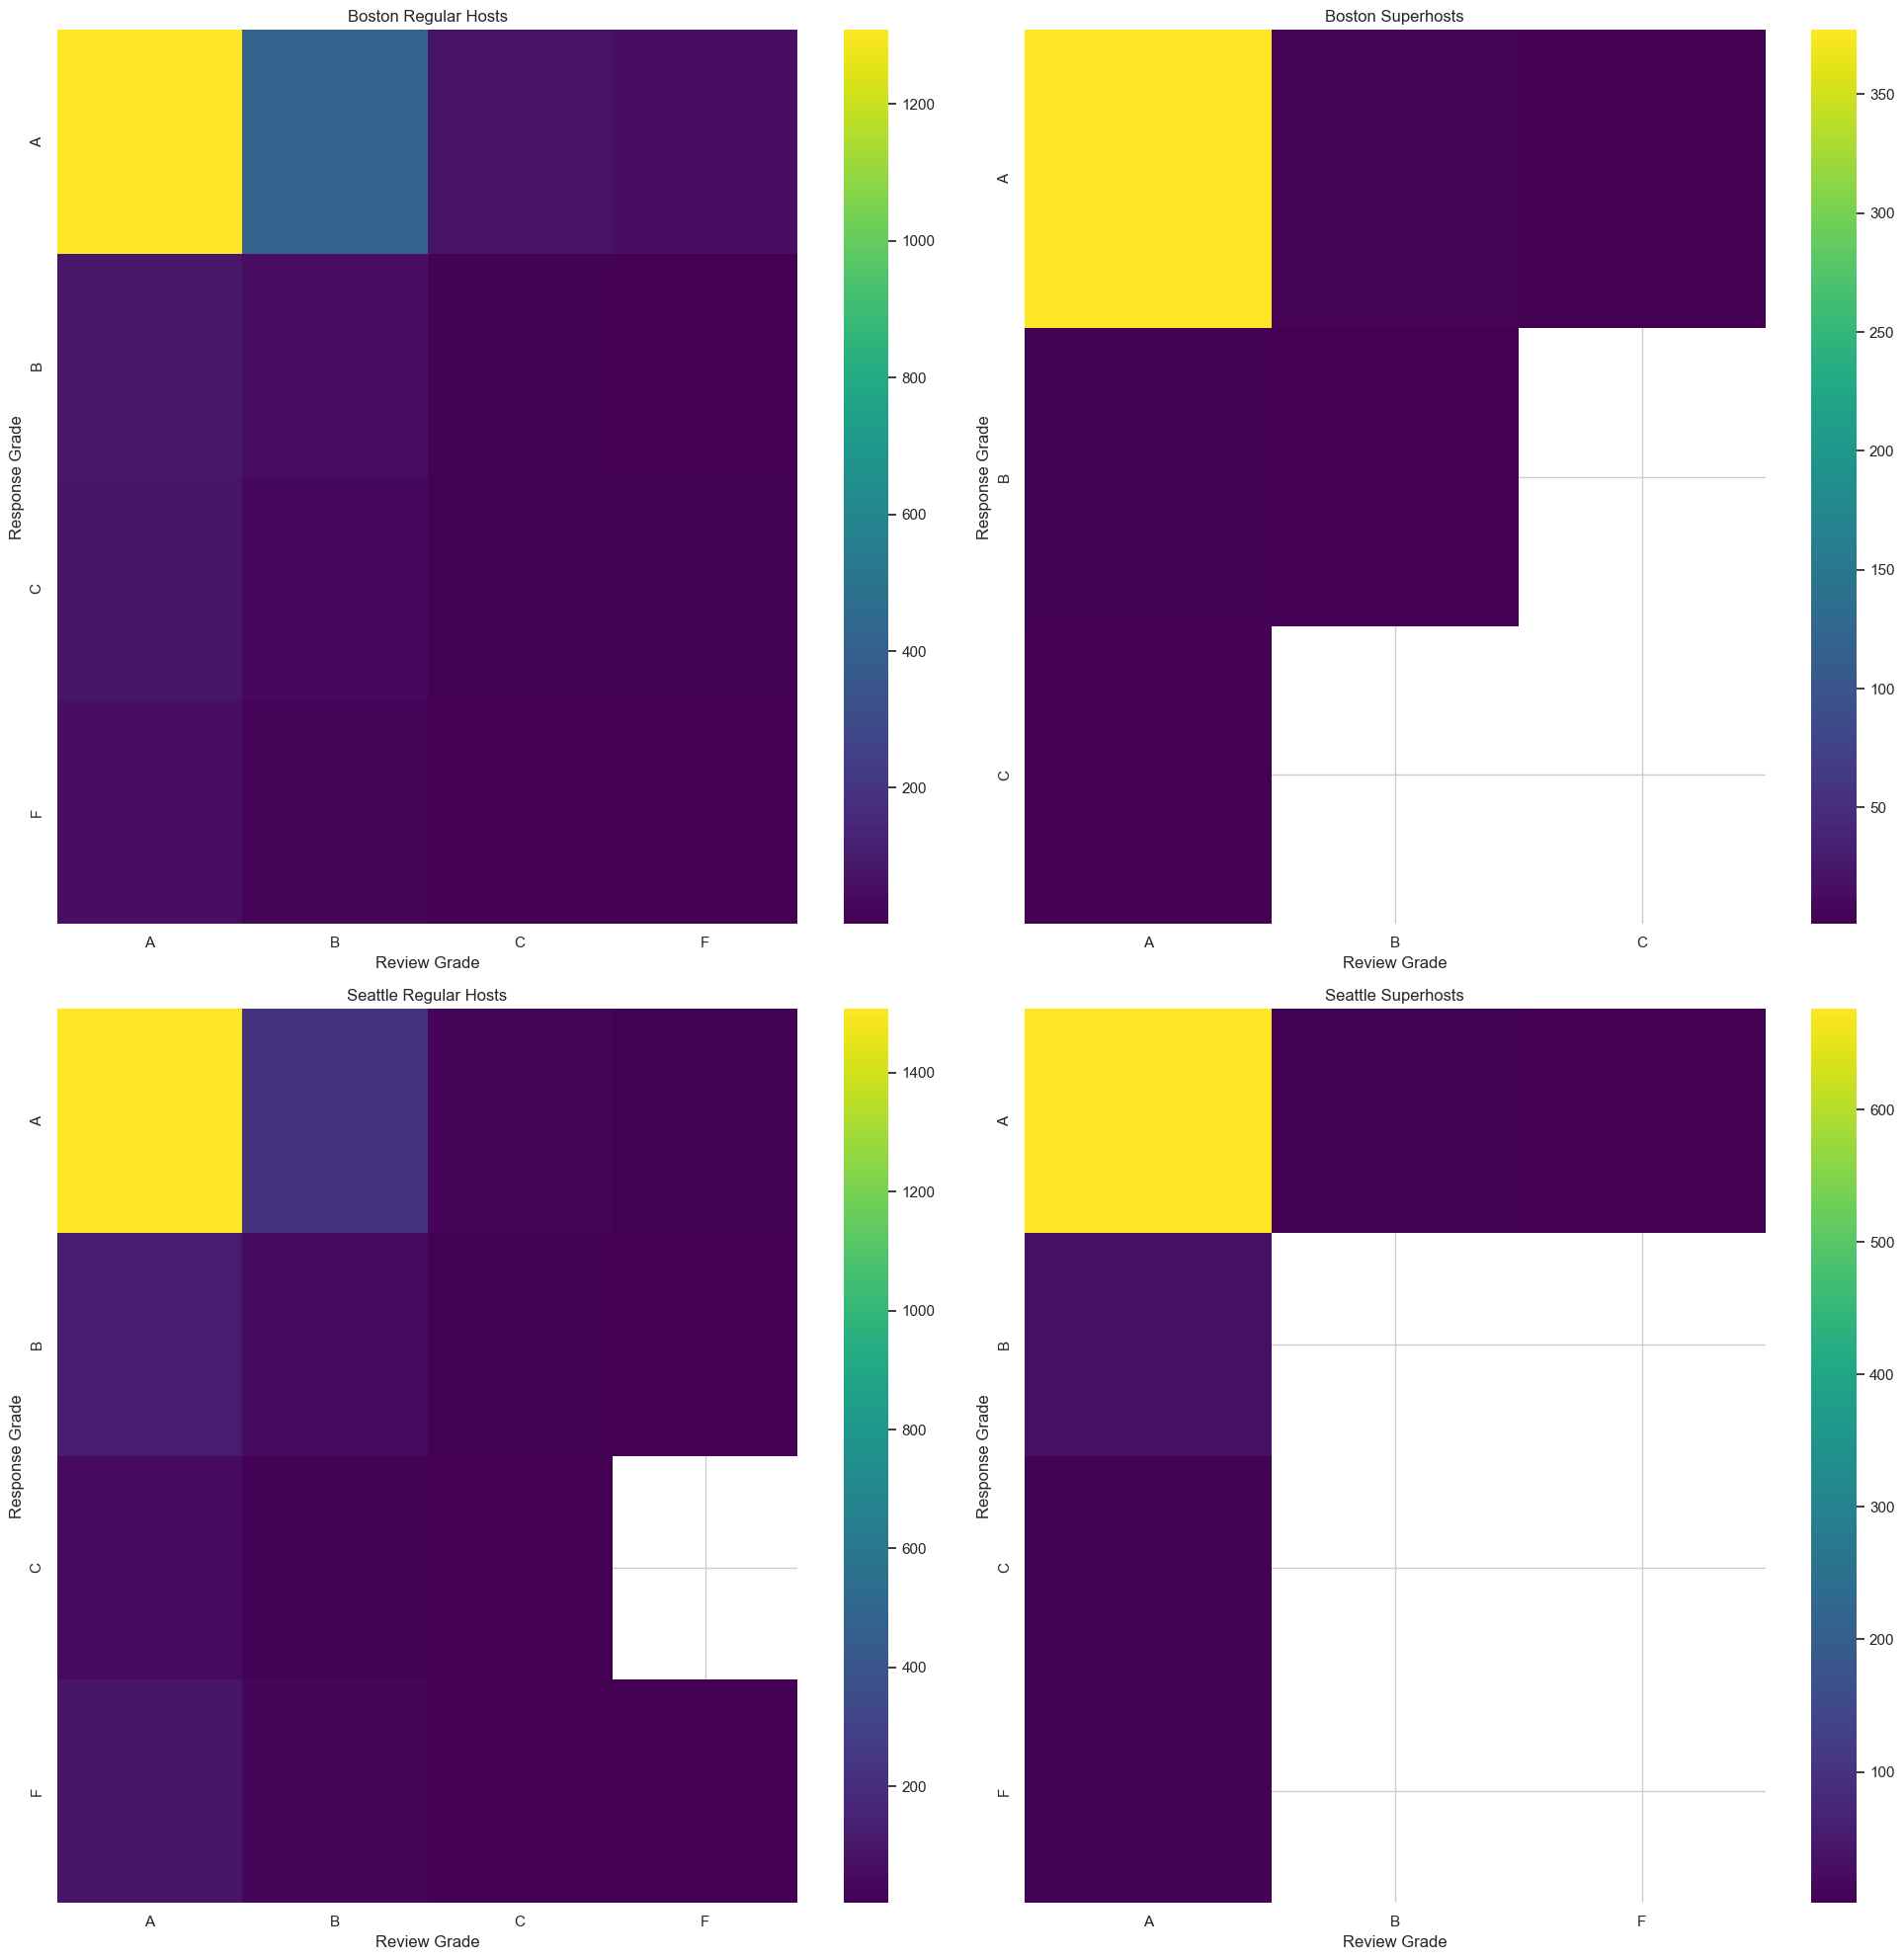

In [ ]:
# Creating a copy of the combined listings dataframe and only keeping the columns that are needed for the analysis
super_host_v_response_rate = combined_listings[['id', 'city', 'host_is_superhost', 'host_response_rate', 'review_scores_rating', 'price']].copy()

# Assigning a letter grade to the review ratings and host response rates
super_host_v_response_rate['review_grade'] = super_host_v_response_rate['review_scores_rating'].apply(rate_to_grade)
super_host_v_response_rate['response_grade'] = super_host_v_response_rate['host_response_rate'].apply(rate_to_grade)

# Excluding the listings with no review rating or host response rate
super_host_v_response_rate = super_host_v_response_rate[ ( super_host_v_response_rate['review_grade'] != 'N/A' ) & ( super_host_v_response_rate['response_grade'] != 'N/A' ) ]

# Getting pairs of city and superhost status to iterate through to generate separate graphs for each pair for better readability
city_superhost_pairs = super_host_v_response_rate[['city', 'host_is_superhost']].drop_duplicates().values.tolist()
# Setting up the subplots for the graphs
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Used for tracking the subplot position
subplot_x = 0
subplot_y = 0

# Iterating through the city and superhost status pairs to generate the graphs
for pair_index, pair in enumerate(city_superhost_pairs):
    if pair_index >= 2:
        subplot_x = 1
        subplot_y = pair_index - 2
    else:
        subplot_y = pair_index

    city = pair[0]
    superhost_status = pair[1]

    # Getting the data for the current city and superhost status
    city_data = super_host_v_response_rate[ (super_host_v_response_rate['city'] == city) & (super_host_v_response_rate['host_is_superhost'] == superhost_status) ]
    
    # Creating a pivot table to display the number of listings by response grade and review grade so it is easier to create a heatmap
    pivot_table = city_data.pivot_table(
        values='price', 
        index='response_grade', 
        columns='review_grade', 
        aggfunc='count'
    )
    
    # Adding the heatmap to the appropriate subplot
    sns.heatmap(pivot_table, ax=axes[subplot_x, subplot_y], cmap='viridis')
    axes[subplot_x, subplot_y].set_title(f'{city} {superhost_status}s')
    axes[subplot_x, subplot_y].set_xlabel('Review Grade')
    axes[subplot_x, subplot_y].set_ylabel('Response Grade')

plt.tight_layout()
plt.show()

# Using a model to find the best combination of columns for estimating price

## Functions for cleaning up data and running a linear regression model then scoring it with R2 and Mean Squared Error

In [ ]:
# Lists used for filling in missing values with the appropriate data type for each column
na_cols_to_fill_str = [ 'host_response_time', 'host_neighbourhood', 'property_type', 'host_is_superhost', 'host_verifications', 'host_identity_verified' ]
na_cols_to_fill_num = [ 'host_response_rate', 'host_acceptance_rate', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee' ]
na_cols_to_fill_1 = ['host_listings_count', 'host_total_listings_count']
na_cols_to_drop_nas = [ 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month' ]

def model_and_score(df):
    """
    Separates the data into training and testing sets, creates and trains a linear regression model, and evaluates the model using the R^2 and mean squared error scores.

    Parameters:
    df (pandas Dataframe): The dataframe containing only the columns that used for the model, as well as the price since that is what is being estimated.

    Returns:
    r2: The R^2 score of the model.
    mse: The mean squared error of the model.
    """
    # Prepare the data
    X = df.drop( columns=['price'] )
    y = df['price']

    # Convert categorical variables to dummy variables
    X = pd.get_dummies(X, drop_first=True)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    return r2, mse

def test_col_combos(df, col_combo):
    """
    Iterates through the combination of columns to clean the columns before passing onto the model. 
    Tests and scores the model based on the R^2 and mean squared error scores.

    Parameters:
    df (pandas Dataframe): The dataframe containing the columns to be used for the model.
    col_combo (list): The combination of columns to be used for the estimation of price.

    Returns:
    str: The letter grade corresponding to the rating.
    """
    df = df[ [ *col_combo, 'price' ] ].copy()

    # Clean up the columns before passing them to the model
    for col_nm in df.columns:
        if col_nm in na_cols_to_fill_str:
            df[col_nm] = df[col_nm].fillna('Unknown')
        elif col_nm in na_cols_to_fill_num:
            df[col_nm] = df[col_nm].fillna(0)
        elif col_nm in na_cols_to_fill_1:
            df[col_nm] = df[col_nm].fillna(1)
        elif col_nm in na_cols_to_drop_nas:
            df = df.dropna(subset=[col_nm])

    # Get the R^2 and mean squared error scores with the current column combination
    r2, mse = model_and_score(df)
    # Return the scores and the columns used for the model
    return {
        "columns": col_combo,
        "r2": r2,
        "mse": mse
    }

## Iterating through the column combinations

In [ ]:
# Columns that should be excluded from the model due to complexity or amount of null values
columns_to_exclude_for_modeling = ['id', 'price', 'weekly_price', 'monthly_price', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'first_review', 'last_review', 'review_scores_value']
# Get all the columns that can be used for the model
all_possible_cols = [ cn for cn in combined_listings.columns.tolist() if cn not in columns_to_exclude_for_modeling ]

# Get all possible combinations of 5 columns to test
all_possible_col_combinations = list( combinations(all_possible_cols, 5) )

# Holds the results of the model testing
results = []

# Iterate through all the possible column combinations and test the model
# Using the tqdm library to show a progress bar
for col_combo in tqdm(all_possible_col_combinations):
    results.append( test_col_combos(combined_listings, col_combo) )

# Convert the results to a dataframe and sort by the R^2 score in descending order
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='r2', ascending=False)

# Get the best R^2 score and the columns used for the model
best_r2 = results_df.iloc[0]
print(best_r2)

100%|██████████| 658008/658008 [1:43:53<00:00, 105.56it/s] 


columns    (neighbourhood_cleansed, room_type, accommodat...
r2                                                  0.639059
mse                                               3255.59671
Name: 500588, dtype: object


## Producing charts for the column combination with the best R^2 score

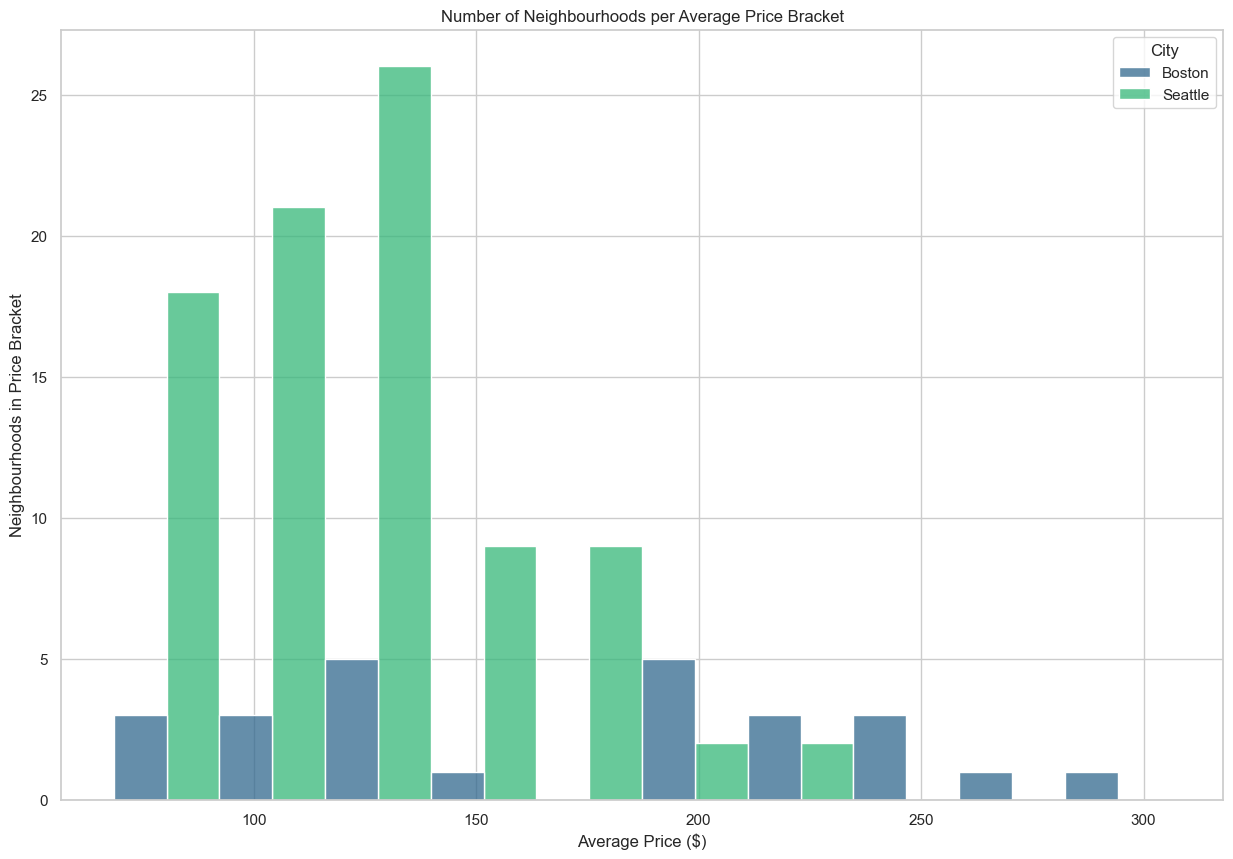

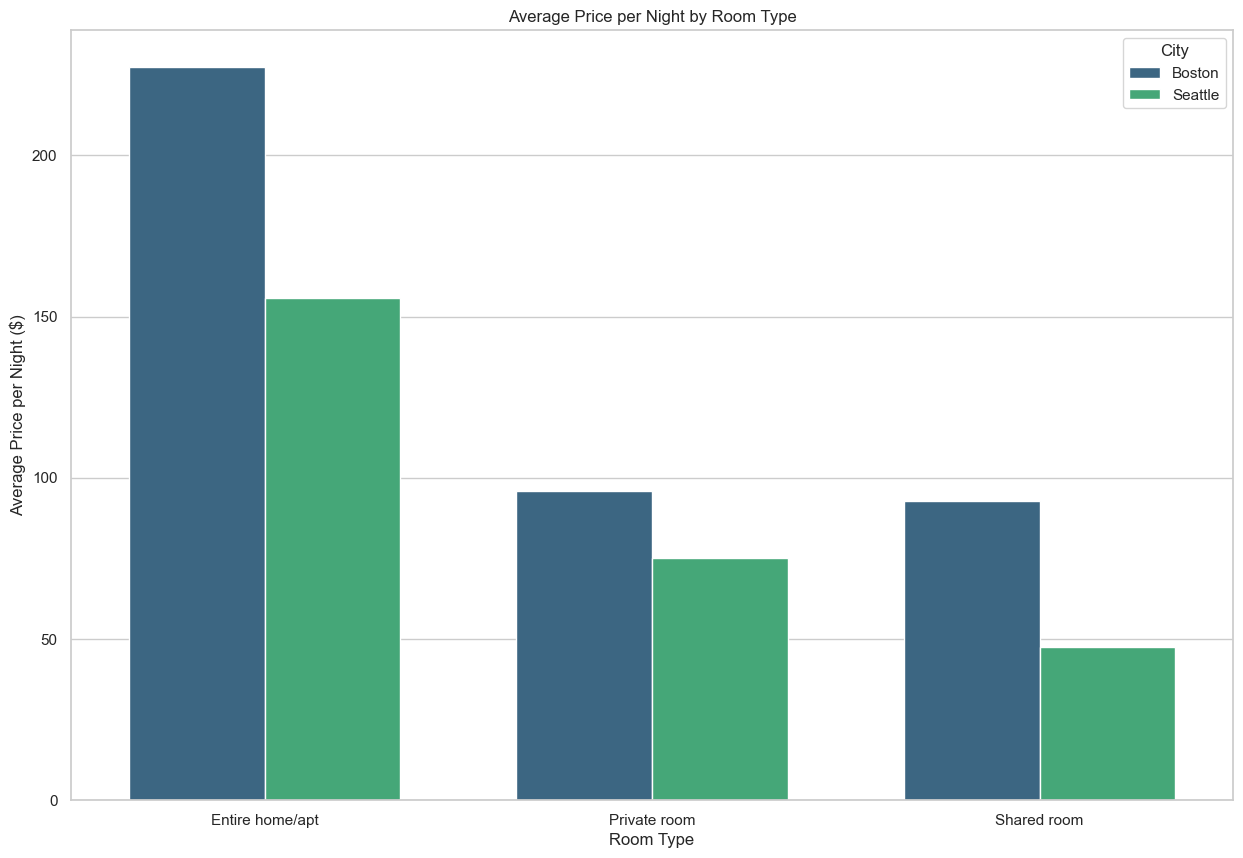

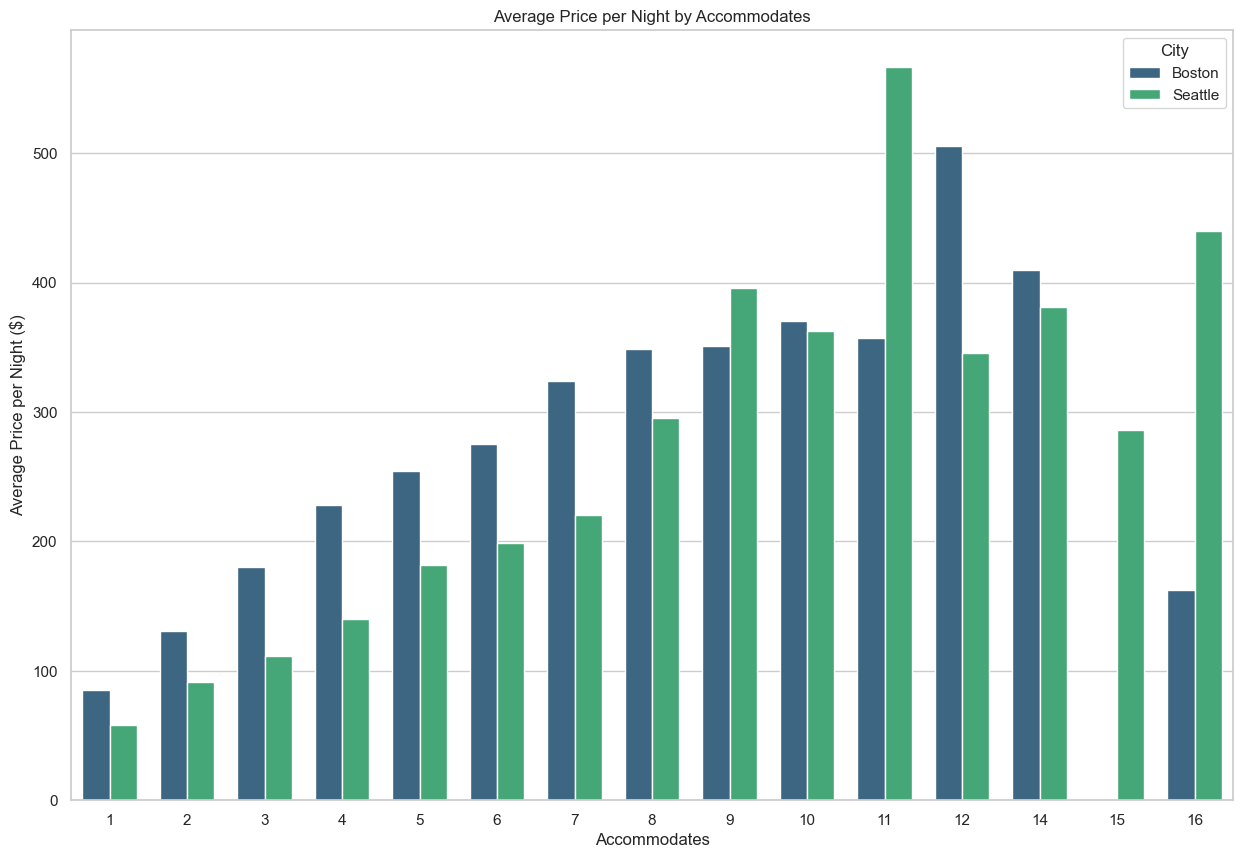

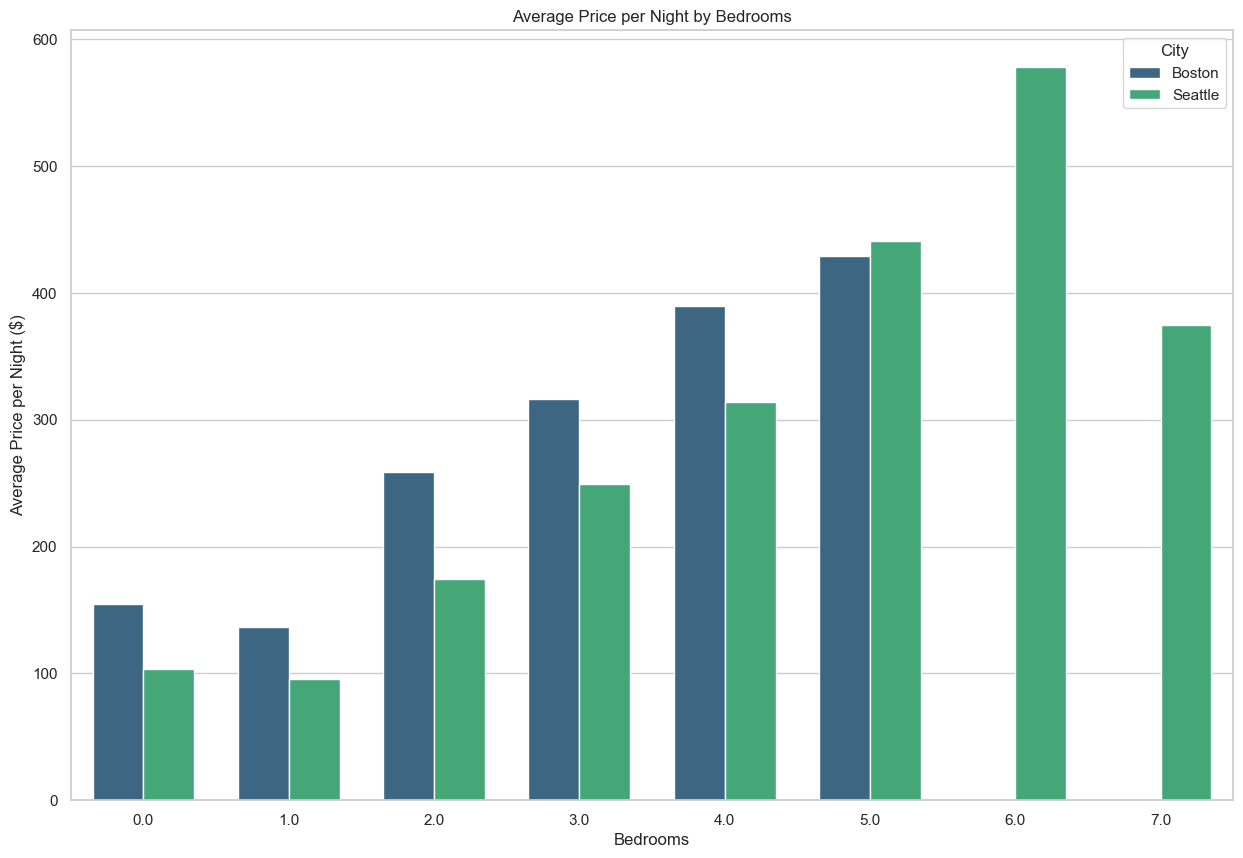

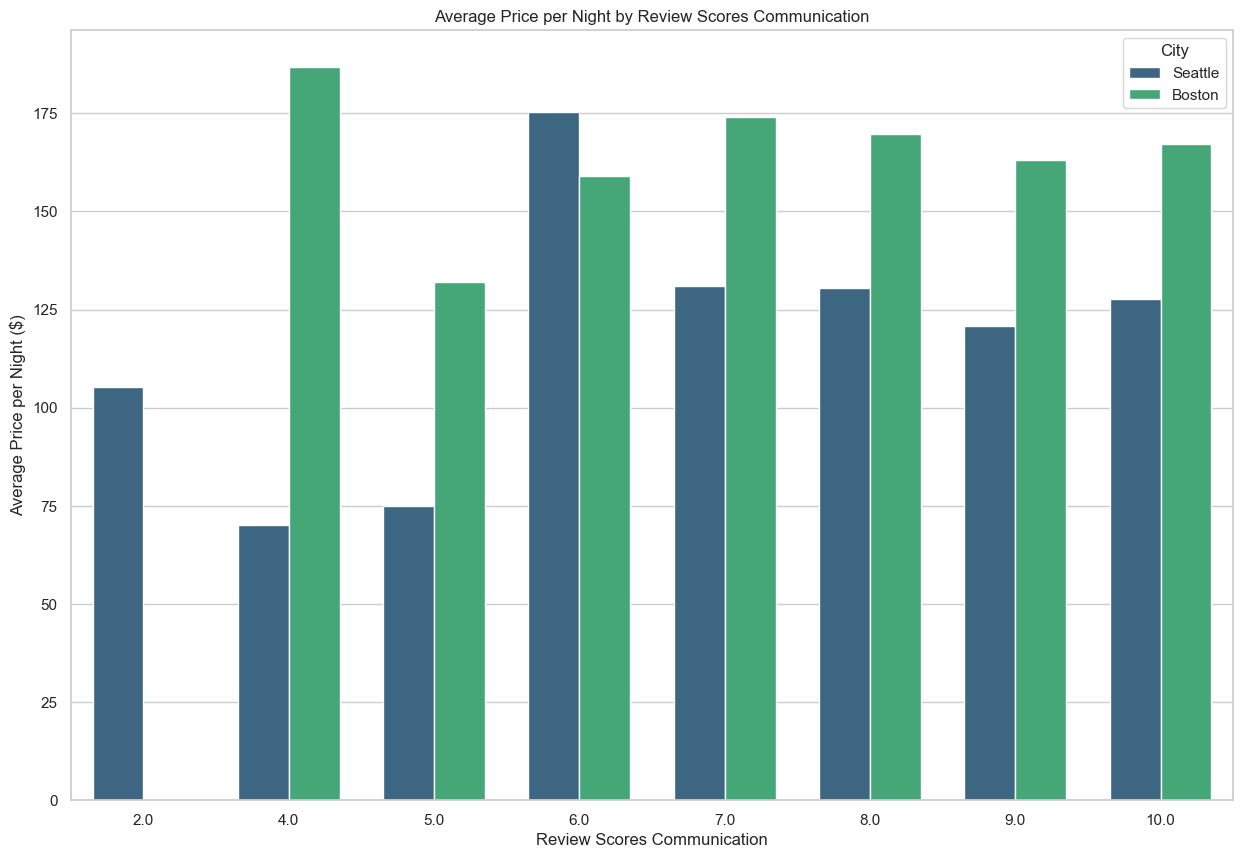

In [ ]:
# These are the column combination with the best R^2 score
best_columns = list(best_r2['columns'])

# Generate charts per column to compare the average prices.
for cn in best_columns:
    # Get the average price per city and superhost status
    average_price_per_col = combined_listings.groupby(['city', cn])['price'].mean().reset_index()
    # Renaming 'city' to 'City' for better display in graph
    average_price_per_col.rename(columns={'city': 'City'}, inplace=True)
    
    # Rounding the average price to 2 decimal places to cleaner display
    average_price_per_col['price'] = average_price_per_col['price'].round(2)
    cn_display = cn.replace("_", " ").title()
    plt.figure(figsize=(15, 10))

    # There are too many neighborhoods to display, so calculate the number of neighborhoods and display as a histogram
    if cn == 'neighbourhood_cleansed':
        average_price_per_col_graph = sns.histplot(data=average_price_per_col, x='price', hue='City', multiple='dodge', bins=10, palette='viridis')
        plt.title(f'Number of Neighbourhoods per Average Price Bracket')
        plt.xlabel('Average Price ($)')
        plt.ylabel('Neighbourhoods in Price Bracket')
        plt.show()

    # Plotting the average price per night by city, superhost status, and the column as a bar chart
    else:
        average_price_per_col_graph = sns.barplot( 
            data=average_price_per_col, x=cn, y='price', hue='City', 
            palette='viridis', width=0.7
        )
        average_price_per_col_graph.set_title(f'Average Price per Night by {cn_display}')
        average_price_per_col_graph.set_xlabel(cn_display)
        average_price_per_col_graph.set_ylabel('Average Price per Night ($)')
        plt.show()